In [1]:
import pandas as pd
from deap import base, creator, tools, algorithms
import numpy as np
import jenkspy
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="deap.creator")
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [2]:
df = pd.read_csv("./data/df_score_V2.csv", index_col=[0])

# Jenks

In [3]:
scores_clients = df["Score_ind"]
nombre_de_classes = 6 

breaks = jenkspy.jenks_breaks(scores_clients, nombre_de_classes)
print(breaks)

[0.0, 164.5569620253165, 370.253164556962, 522.1518987341772, 645.5696202531645, 772.1518987341772, 1000.0]


In [4]:
breaks = [0.0, 210, 356, 508, 636, 771, 900.0]

df["Classes"] = np.digitize(df["Score_ind"], bins=sorted(breaks))

resultats = df.groupby("Classes").agg(
    moyenne_TARGET=("TARGET", "mean"),
    nb_individus=("TARGET", "size"), 
)
resultats['taux_individus'] = (resultats['nb_individus'] / df.shape[0]) * 100

print(resultats)

         moyenne_TARGET  nb_individus  taux_individus
Classes                                              
1              0.278027          8028        2.867143
2              0.173381         26214        9.362143
3              0.115419         35826       12.795000
4              0.079426         44746       15.980714
5              0.051911         75340       26.907143
6              0.032603         72417       25.863214
7              0.024442         17429        6.224643


In [5]:
df["date_mensuelle"] = pd.to_datetime(df["date_mensuelle"])
df['date_trimestrielle'] = df['date_mensuelle'].dt.year.astype(str) + '_' + df['date_mensuelle'].dt.quarter.astype(str)

In [6]:
def plot_stability_taux(train, variable):
    stability_df = train.groupby(['date_trimestrielle', variable])['TARGET'].mean().unstack()
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

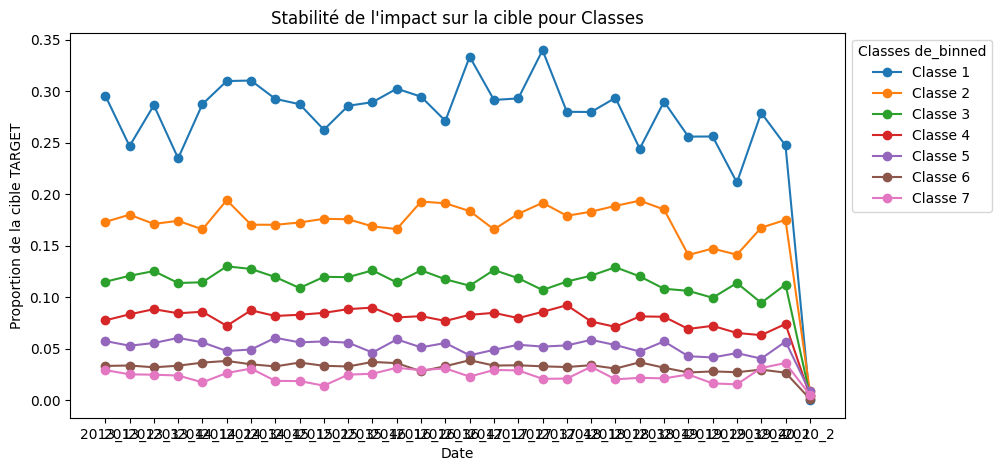

In [7]:
plot_stability_taux(df, "Classes")

# Génétique

In [8]:
df["Score_2"] = [np.random.randint(0,1000) for _ in range(df.shape[0])]

In [9]:
def taux_defaut(limites):
    df["Classes"] = np.digitize(df["Score_ind"], bins=limites)
    defaut = df.groupby("Classes")["TARGET"].mean()
    return defaut

def evalSegmentation1(individu):
    limites = sorted(individu)  
    taux = taux_defaut(limites)
    
    if len(taux) != 7 : 
        return(0, )
    if all(taux[i] <= taux[i+1] for i in range(1, len(taux)-1)):
        return len(set(np.digitize(df["Score_ind"], bins=limites))),
    else : 
        return 0,
    
def evalSegmentation(individu, seuil_minimum=7):
    limites = sorted(individu)
    taux = taux_defaut(limites)
    
    if len(taux)<7 : 
        penalites_seuil = 7 - len(taux)
        fitness = -(penalites_seuil * 100) 
    else : 
        diffs = [taux[i+1] - taux[i] for i in range(1, len(taux)-1)]
        penalites_diffs = sum(d < 0 for d in diffs)
        fitness = sum(d for d in diffs if d > 0) - (penalites_diffs * 100) 
    return fitness,

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, min(df["Score_ind"]), max(df["Score_ind"])) 
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=6)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def checkBounds(min, max):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.decorate("mate", checkBounds(min(df["Score_ind"]), max(df["Score_ind"])))
toolbox.decorate("mutate", checkBounds(min(df["Score_ind"]), max(df["Score_ind"])))

toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalSegmentation)

population = toolbox.population(n=50)
CXPB, MUTPB, NGEN = 0.5, 0.2, 40

for gen in range(NGEN):
    print(f"Generation: {gen + 1}")
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

    best_ind = tools.selBest(population, 1)[0]
    print(f"  Meilleur individu: {sorted(best_ind)}, Fitness: {best_ind.fitness.values}")

best_ind = tools.selBest(population, 1)[0]
print("Meilleur individu est %s, %s" % (best_ind, best_ind.fitness.values))

Generation: 1
  Meilleur individu: [3.9679234605664027, 120.98020618081095, 664.7732333124238, 737.9727765667064, 746.8308031900705, 980.3404735139829], Fitness: (-100.0,)
Generation: 2
  Meilleur individu: [7.8183646173231836, 172.44487773286352, 241.64917945526642, 438.3133126404253, 688.727377080586, 690.8388861292153], Fitness: (-100.0,)
Generation: 3
  Meilleur individu: [0.0, 129.56337771797843, 212.68573345475232, 512.6465457799081, 678.2705216596041, 1000.0], Fitness: (-100.0,)
Generation: 4
  Meilleur individu: [0.0, 265.90253414578234, 272.84884727066213, 285.1269854438509, 435.7906668540918, 877.9831011953596], Fitness: (-100.0,)
Generation: 5
  Meilleur individu: [0.0, 265.90253414578234, 278.0897965457433, 285.1269854438509, 435.7906668540918, 877.9831011953596], Fitness: (-100.0,)
Generation: 6
  Meilleur individu: [0.0, 125.3168359169072, 252.87306831424695, 577.494180952481, 667.7289901997016, 1000.0], Fitness: (-100.0,)
Generation: 7
  Meilleur individu: [0.0, 77.67750

In [10]:
df["Classes"] = np.digitize(df["Score_2"], bins=sorted(best_ind))
defaut_par_segment = df.groupby("Classes")["TARGET"].mean()

# taux de défaut moyen pour chaque classe ou segment
defaut_par_segment

Classes
1    0.076184
2    0.067797
3    0.072998
4    0.074408
5    0.076006
6    0.074799
Name: TARGET, dtype: float64

In [11]:
stop 

NameError: name 'stop' is not defined

# MoC A

In [15]:
# LRA représente le taux de défaut moyen observé sur toutes les observations.
# Calcul du taux de défaut moyen observé (LRA)
LRA = df["TARGET"].mean()
LRA

0.07558571428571428

In [16]:
# Calcul du taux de défaut pour chaque classe ou segment
# defaut_par_segment = df.groupby("Classes")["TARGET"].mean()

# Comparaison entre le taux de défaut moyen observé (LRA) et le taux de défaut de chaque classe ou segment
difference_par_segment = defaut_par_segment - LRA

# Affichage des résultats
print("Taux de défaut moyen observé (LRA) :", LRA)
print("Différence entre le taux de défaut moyen observé (LRA) et le taux de défaut de chaque classe ou segment :")
print(difference_par_segment)

Taux de défaut moyen observé (LRA) : 0.07558571428571428
Différence entre le taux de défaut moyen observé (LRA) et le taux de défaut de chaque classe ou segment :
Classes
1    0.000599
2   -0.007789
3   -0.002588
4   -0.001178
5    0.000420
6   -0.000786
Name: TARGET, dtype: float64


y a pas grande différence entre LRA et defaut_par_segment 

2) missing information for the purpose of estimating loss rates or for the purpose of reflecting economic downturn in LGD estimates;

In [17]:
# Vérifier s'il y a des valeurs manquantes dans les variables utilisées pour estimer la probabilité de défaut (PD)
missing_values = df.isnull().sum()
print("Valeurs manquantes dans les variables utilisées pour PD :\n", missing_values)


Valeurs manquantes dans les variables utilisées pour PD :
 date_mensuelle                           0
TARGET                                   0
DAYS_BIRTH_disc_int                      0
EXT_SOURCE_2_disc_int                    0
EXT_SOURCE_1_disc_int                    0
AMT_CREDIT_SUM_disc_int                  0
AMT_CREDIT_SUM_DEBT_disc_int             0
AMT_GOODS_PRICE_disc_int                 0
DAYS_REGISTRATION_disc_int               0
DAYS_LAST_PHONE_CHANGE_disc_int          0
EXT_SOURCE_3_disc_int                    0
AMT_CREDIT_disc_int                      0
AMT_ANNUITY_disc_int                     0
REGION_POPULATION_RELATIVE_disc_int      0
DAYS_EMPLOYED_disc_int                   0
DAYS_ID_PUBLISH_disc_int                 0
AMT_REQ_CREDIT_BUREAU_MON_disc_int       0
OWN_CAR_AGE_disc_int                     0
YEARS_BEGINEXPLUATATION_MEDI_disc_int    0
YEARS_BEGINEXPLUATATION_MODE_disc_int    0
YEARS_BEGINEXPLUATATION_AVG_disc_int     0
NAME_INCOME_TYPE_discret              

In [18]:
# Examiner les dates de début et de fin dans vos données
date_debut = df['date_trimestrielle'].min()
date_fin = df['date_trimestrielle'].max()
print("Date de début :", date_debut)
print("Date de fin :", date_fin)

Date de début : 2013_1
Date de fin : 2020_2


pas de période manquantes dans BdD

In [23]:
# Créer une liste de toutes les périodes attendues
periodes_attendues = [f"{year}_{quarter}" for year in range(2013, 2021) for quarter in range(1, 5)]

# Extraire les périodes réellement présentes dans vos données
periodes_reelles = df['date_trimestrielle'].unique()

# Vérifier les périodes manquantes
periodes_manquantes = set(periodes_attendues) - set(periodes_reelles)
print("Périodes manquantes dans les données :", periodes_manquantes)

Périodes manquantes dans les données : {'2020_3', '2020_4'}


## crise COVID

In [24]:
# Ajouter une colonne pour indiquer la période de crise COVID
df['periode_crise_covid'] = (df['date_trimestrielle'] == '2020_1')

# Diviser vos données en périodes de crise COVID et périodes non-crise COVID
periode_crise_covid = df[df['periode_crise_covid'] == True]
periode_non_crise_covid = df[df['periode_crise_covid'] == False]

écart entre le taux de défaut pendant la période de crise COVID et le taux de défaut moyen observé sur tt la période 

In [27]:
# 1. Calculer le taux de défaut moyen observé (LRA) sur toute la période
LRA_total = df['TARGET'].mean()

# Filtrer les données pour inclure les trimestres 2020_1 et 2020_2
periode_covid = df[df['date_trimestrielle'].isin(['2020_1', '2020_2'])]

# Calculer le taux de défaut moyen pendant la période de crise COVID
taux_defaut_covid = periode_covid['TARGET'].mean()

# Comparer avec le taux de défaut moyen observé sur toute la période
ecart = taux_defaut_covid - LRA_total

# Afficher les résultats
print("Taux de défaut moyen observé sur toute la période (LRA) :", LRA_total)
print("Taux de défaut moyen pendant la période de crise COVID :", taux_defaut_covid)
print("Écart entre le taux de défaut moyen pendant la crise COVID et le taux de défaut moyen observé sur toute la période :", ecart)


Taux de défaut moyen observé sur toute la période (LRA) : 0.07558571428571428
Taux de défaut moyen pendant la période de crise COVID : 0.05849718528187974
Écart entre le taux de défaut moyen pendant la crise COVID et le taux de défaut moyen observé sur toute la période : -0.017088529003834542


In [28]:
moc_a_covid=-ecart
moc_a_covid

0.017088529003834542

écart entre le taux de défaut pendant la période de crise COVID et le taux de défaut moyen observé sans la crise COVID.

In [30]:
# 1. Calculer le taux de défaut moyen observé sur toute la période, en excluant la période de crise COVID
periode_non_covid = df[~df['date_trimestrielle'].isin(['2020_1', '2020_2'])]
LRA_sans_covid = periode_non_covid['TARGET'].mean()

# 2. Calculer le taux de défaut moyen pendant la période de crise COVID
periode_covid = df[df['date_trimestrielle'].isin(['2020_1', '2020_2'])]
taux_defaut_covid = periode_covid['TARGET'].mean()

# 3. Comparer ces deux taux pour déterminer s'ils sont significativement différents
if taux_defaut_covid != LRA_sans_covid:
    print("Il y a une différence entre le taux de défaut pendant la période de crise COVID et le taux de défaut moyen observé sans la crise COVID.")
else:
    print("Il n'y a pas de différence significative entre le taux de défaut pendant la période de crise COVID et le taux de défaut moyen observé sans la crise COVID.")
# Calculer l'écart entre le taux de défaut moyen pendant la période de crise COVID et le taux de défaut moyen observé sans la crise COVID
ecart_covid = taux_defaut_covid - LRA_sans_covid

# Afficher l'écart
print("Écart entre le taux de défaut moyen pendant la crise COVID et le taux de défaut moyen observé sans la crise COVID :", ecart_covid)


Il y a une différence entre le taux de défaut pendant la période de crise COVID et le taux de défaut moyen observé sans la crise COVID.
Écart entre le taux de défaut moyen pendant la crise COVID et le taux de défaut moyen observé sans la crise COVID : -0.01787082433928682


## identifier la marge de conservatisme associée aux variables manquantes

In [31]:
train = pd.read_csv("./data/application_train_vf.csv")
train_prepared = pd.read_csv("./data/train_preparedV2.csv", index_col=[0])

# 1. Calculer le taux de défaut moyen observé avant l'imputation des valeurs manquantes
LRA_avant_imputation = train['TARGET'].mean()

# 2. Calculer le taux de défaut moyen observé après l'imputation des valeurs manquantes
LRA_apres_imputation = train_prepared['TARGET'].mean()

# 3. Calculer la marge de conservatisme
marge_conservatisme = LRA_apres_imputation - LRA_avant_imputation

# 4. Afficher les résultats
print("Taux de défaut moyen observé avant l'imputation des valeurs manquantes :", LRA_avant_imputation)
print("Taux de défaut moyen observé après l'imputation des valeurs manquantes :", LRA_apres_imputation)
print("Marge de conservatisme due à l'imputation des valeurs manquantes :", marge_conservatisme)

Taux de défaut moyen observé avant l'imputation des valeurs manquantes : 0.07671500488391314
Taux de défaut moyen observé après l'imputation des valeurs manquantes : 0.07558571428571428
Marge de conservatisme due à l'imputation des valeurs manquantes : -0.0011292905981988566


## moc A sum 

In [33]:
marge_conservatisme_tot = -marge_conservatisme + moc_a_covid
marge_conservatisme_tot

0.0182178196020334